# 1. Model Development Using Training Set

## 1.1 Model Development

In [6]:
library(ggplot2)
library(data.table)
library(zoo)
library(plyr)
library(pls)
library(stringr)


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'pls'

The following object is masked from 'package:stats':

    loadings



In [119]:
# Load processed data obtained from Data_Process.ipynb
data <- fread("data_winsorized_withoutNAreplace.csv")

In [120]:
# Generate Momentum Factors
data <- data[, ctmp_returns := shift(fwd_returns, 1), by = stock]
data <- data[, len := .N, by = stock]
data <- data[, ":="(
            # Return of the most recent past month
            F21 = ctmp_returns, 
            # MA of past 3 months' returns
            F22 = ifelse(len >= 3, rollapply(ctmp_returns, 3, mean, fill = NA, align = "right"), as.numeric(NA)), 
            # MA of past 6 months' returns
            F23 = ifelse(len >= 6, rollapply(ctmp_returns, 6, mean, fill = NA, align = "right"), as.numeric(NA)), 
            # MA of past 12 months' returns
            F24 = ifelse(len >= 12, rollapply(ctmp_returns, 12, mean, fill = NA, align = "right"), as.numeric(NA))
), by = stock]

In [127]:
## Split into test/training set
# Since we are analyzing time series, for simplicity, take the observations on the first 70% days as training set,
# and the observations on the remaining 30% days as test set
split_date = length(unique(data$date)) * 0.7 # 84 out of 120 days
data_train <- data[as.numeric(substr(date, 2, 4)) <= split_date,]
data_test <- data[as.numeric(substr(date, 2, 4)) > split_date,]

# Order by date and stock
data_train <- data_train[order(stock, date),]
data_test <- data_test[order(stock, date),]

In [130]:
# Check if the training set is a good representative of the full dataset

# Function to compare statistics
compare_stats <- function(data_nm1, data_nm2){
    data1 <- get(data_nm1)
    data2 <- get(data_nm2)
    for (nm in colnames(data1)[2:dim(data1)[2]]){
        cat(nm, "\ndata_nm1:\n")
        print(summary(data1[[nm]]))
        cat("data_nm2:\n")
        print(summary(data2[[nm]]))
        cat("\n")
}}

# Compare
compare_stats("data", "data_train")

date 
data_nm1:
   Length     Class      Mode 
    74855 character character 
data_nm2:
   Length     Class      Mode 
    54104 character character 

fwd_returns 
data_nm1:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-28.2596  -3.8840   1.0417   0.9219   5.7935  30.8352 
data_nm2:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-28.2596  -4.2955   1.0121   0.8719   6.0889  30.8352 

F01 
data_nm1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.2681  0.8650  1.5891  2.1758  2.8376  7.1494     606 
data_nm2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.2681  0.8082  1.4773  2.0759  2.6912  7.1494     512 

F02 
data_nm1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.000   3.000   3.775   5.000   9.000     202 
data_nm2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.000   3.000   3.805   6.000   9.000     143 

F03 
data_nm1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1703    4887

- ### Univariate Regressions
#### Elementary study of the predictive power of each single variable through univariate regressions.
#### And we can check whether their performance in the multi-variate regressions meet our expectation (observations here).

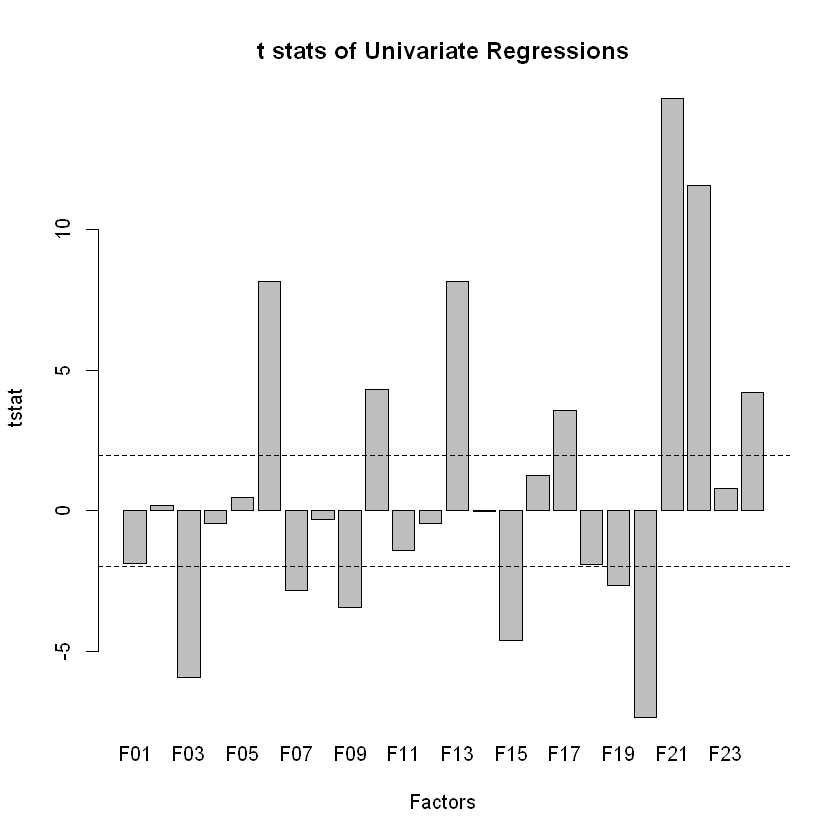

In [151]:
# List contains names of independent variables
factor_str_list = c()
for (i in c(1:24)) {
    factor_str_list = c(factor_str_list, paste('F', str_pad(as.character(i), 2, side = 'left', pad = '0'), sep=''))
}

# Matrix to store t values
tstat <- matrix(NA, 24, 1)
colnames(tstat) <- "t_stat"
rownames(tstat) <- factor_str_list

for (i in c(1:24)) {
    factor_string = factor_str_list[i]
    data_train[['x']] = data_train[[factor_string]]
    tstat[i,1] <- summary(lm(fwd_returns ~ x, na.action = na.exclude, data_train))$coef[2,3]
}

# Plot t_stats
barplot(tstat[,1], ylab = "tstat", xlab = "Factors", main = "t stats of Univariate Regressions")
abline(h = c(-1.96, 1.96), lty = 2)

In [146]:
names(data_train)
dim(data_train)

[1] "stock"       "date"        "fwd_returns" "F01"         "F02"        
 [6] "F03"         "F04"         "F05"         "F06"         "F07"        
[11] "F08"         "F09"         "F10"         "F11"         "F12"        
[16] "F13"         "F14"         "F15"         "F16"         "F17"        
[21] "F18"         "F19"         "F20"         "F21"         "F22"        
[26] "F23"         "F24"

[1] 54104    27

- ### Multi-variate Regressions
#### Take the interaction of factors into account

In [147]:
data_train <- data_train[, c(1:23, 26:29)] # remove useless columns

ERROR: Error in `[.data.table`(data_train, , c(1:23, 26:29)): Item 26 of j is 28 which is outside the column number range [1,ncol=27]


In [152]:
# First, start from putting all factors into the multi-variate regression
summary(lm(fwd_returns ~ ., na.action = na.exclude, data_train[, c(3:27)]))


Call:
lm(formula = fwd_returns ~ ., data = data_train[, c(3:27)], na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.814  -5.235   0.286   5.393  37.300 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.751e-01  3.745e-01  -1.536  0.12466    
F01         -2.011e-02  4.350e-02  -0.462  0.64383    
F02          9.299e-05  2.191e-02   0.004  0.99661    
F03         -5.555e-06  6.282e-06  -0.884  0.37652    
F04         -8.158e-02  4.681e-02  -1.743  0.08139 .  
F05          2.087e-02  5.010e-03   4.166 3.11e-05 ***
F06         -2.756e-01  1.755e-02 -15.700  < 2e-16 ***
F07          5.491e-02  1.155e-01   0.475  0.63460    
F08         -5.776e-02  8.030e-01  -0.072  0.94266    
F09          8.087e-03  1.359e-02   0.595  0.55182    
F10         -1.491e-03  5.527e-03  -0.270  0.78739    
F11         -3.187e-02  4.097e-02  -0.778  0.43659    
F12         -1.804e-03  6.393e-04  -2.821  0.00479 ** 
F13          6.309e-01  6.322e

- #### Feature Selection

In [ ]:
# Manual selection
data_train1 <- data_train[, c(1:3, 8:9, 15:18, 24:26)]


In [ ]:
# Due to time limit, lasso regression is used here. Otherwise, we can also try stepwise methods based on AIC/SIC criteria
# Lasso

In [150]:
head(data_train1)

stock,date,fwd_returns,F05,F06,F12,F13,F14,F15,F21,F22,F23
S001,D052,-20.313901,NA,NA,NA,NA,0,NA,NA,NA,NA
S001,D053,-9.116488,NA,-14.648974,NA,NA,0,NA,-20.313901,NA,NA
S001,D054,11.455108,NA,-7.714286,NA,NA,0,NA,-9.116488,NA,NA
S001,D055,13.888889,NA,11.455108,NA,NA,0,NA,11.455108,-5.99176,NA
S001,D056,16.585366,NA,13.510520,270.3872,NA,0,NA,13.888889,5.40917,NA
S001,D057,12.384937,NA,16.279303,270.3872,NA,0,NA,16.585366,13.97645,NA


## 1.2 Robutsness Check

- ### By Sector

- ### By Year
#### Given the nature of this particular data set, we can regard 12 consecutive month as a year unit.
#### The year defined here may not start from January, but still covers the full cycle of a year, so that any seasonality (or other calendar related patterns) of the strategies' performance will still be taken care of.

# Model Selection

## In-Sample Backtest for Single Strategies

In [ ]:
sum(1/n * (1 + fwd_return/100)) - sum(1/n * (1 + fwd_return/100)) ## Long & short

## Combined Strategy